### Carga de Librerias

In [1]:
import os 
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import warnings
np.random.seed(34)
warnings.filterwarnings('ignore')


### Carga de datasets

In [2]:
from from_txt_to_csv import importar_txt_a_dataframe as from_txt 

eng_info = ['unit_number', 'time_cycles']
eng_setting = ['operational_setting_1', 'operational_setting_2', 'operational_setting_3']
sensors_name = ['s_{}'.format(i+1) for i in range(0,21)] 
rand_col = ['ccc','ccc1']
column_names = eng_info + eng_setting + sensors_name + rand_col


# Leer el archivo txt (separado por espacios)

#dataset de motors hasta el ciclo en que falla
df_train = pd.read_csv("data/train_FD001.txt", sep=" ", header=None)
df_train.columns = column_names
train_file = df_train.iloc[:, :-2]

#dataset, en donde se realizan pruebas a los motores pero no fallan, 
df_test = pd.read_csv("data/test_FD001.txt", sep=" ", header=None)
df_test.columns = column_names
test_file = df_test.iloc[:, :-2]

#la vida util de los motores
y_rul= pd.read_csv("data/RUL_FD001.txt", sep='\s+',header=None,index_col=False,names=['RUL'])


In [3]:
nom_sensor_real ={}
sensor_list =["(Fan inlet temperature) (◦R)",
              "(LPC outlet temperature) (◦R)",
              "(HPC outlet temperature) (◦R)",
              "(LPT outlet temperature) (◦R)",
              "(Fan inlet Pressure) (psia)",
              "(bypass-duct pressure) (psia)",
              "(HPC outlet pressure) (psia)",
              "(Physical fan speed) (rpm)",
              "(Physical core speed) (rpm)",
              "(Engine pressure ratio(P50/P2)",
              "(HPC outlet Static pressure) (psia)",
              "(Ratio of fuel flow to Ps30) (pps/psia)",
              "(Corrected fan speed) (rpm)",
              "(Corrected core speed) (rpm)",
              "(Bypass Ratio) ",
              "(Burner fuel-air ratio)",
              "(Bleed Enthalpy)",
              "(Required fan speed)",
              "(Required fan conversion speed)",
              "(High-pressure turbines Cool air flow)",
              "(Low-pressure turbines Cool air flow)" ]
i=1
for x in sensor_list :
    nom_sensor_real['s_'+str(i)]=x
    i+=1
nom_sensor_real

{'s_1': '(Fan inlet temperature) (◦R)',
 's_2': '(LPC outlet temperature) (◦R)',
 's_3': '(HPC outlet temperature) (◦R)',
 's_4': '(LPT outlet temperature) (◦R)',
 's_5': '(Fan inlet Pressure) (psia)',
 's_6': '(bypass-duct pressure) (psia)',
 's_7': '(HPC outlet pressure) (psia)',
 's_8': '(Physical fan speed) (rpm)',
 's_9': '(Physical core speed) (rpm)',
 's_10': '(Engine pressure ratio(P50/P2)',
 's_11': '(HPC outlet Static pressure) (psia)',
 's_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 's_13': '(Corrected fan speed) (rpm)',
 's_14': '(Corrected core speed) (rpm)',
 's_15': '(Bypass Ratio) ',
 's_16': '(Burner fuel-air ratio)',
 's_17': '(Bleed Enthalpy)',
 's_18': '(Required fan speed)',
 's_19': '(Required fan conversion speed)',
 's_20': '(High-pressure turbines Cool air flow)',
 's_21': '(Low-pressure turbines Cool air flow)'}

### Analisis EDA

#### Revisión de tipo de datos en el dataset:

In [4]:
train_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   unit_number            20631 non-null  int64  
 1   time_cycles            20631 non-null  int64  
 2   operational_setting_1  20631 non-null  float64
 3   operational_setting_2  20631 non-null  float64
 4   operational_setting_3  20631 non-null  float64
 5   s_1                    20631 non-null  float64
 6   s_2                    20631 non-null  float64
 7   s_3                    20631 non-null  float64
 8   s_4                    20631 non-null  float64
 9   s_5                    20631 non-null  float64
 10  s_6                    20631 non-null  float64
 11  s_7                    20631 non-null  float64
 12  s_8                    20631 non-null  float64
 13  s_9                    20631 non-null  float64
 14  s_10                   20631 non-null  float64
 15  s_

In [5]:
test_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096 entries, 0 to 13095
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   unit_number            13096 non-null  int64  
 1   time_cycles            13096 non-null  int64  
 2   operational_setting_1  13096 non-null  float64
 3   operational_setting_2  13096 non-null  float64
 4   operational_setting_3  13096 non-null  float64
 5   s_1                    13096 non-null  float64
 6   s_2                    13096 non-null  float64
 7   s_3                    13096 non-null  float64
 8   s_4                    13096 non-null  float64
 9   s_5                    13096 non-null  float64
 10  s_6                    13096 non-null  float64
 11  s_7                    13096 non-null  float64
 12  s_8                    13096 non-null  float64
 13  s_9                    13096 non-null  float64
 14  s_10                   13096 non-null  float64
 15  s_

In [6]:
y_rul.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   RUL     100 non-null    int64
dtypes: int64(1)
memory usage: 932.0 bytes


#### Revision inicial del dataset:

In [7]:
# Revisión inicial del archivo de train
train_file.head(5)

,unit_number,time_cycles,operational_setting_1,operational_setting_2,operational_setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [8]:
# Revisión inicial del archivo de test
test_file.head(5)

,unit_number,time_cycles,operational_setting_1,operational_setting_2,operational_setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [9]:
# Revisión inicial del archivo de RUL dado en el dataset. 
y_rul.head(5)

,RUL
0,112
1,98
2,69
3,82
4,91


#### Revisión de nulos:

In [10]:
train_file.isnull().sum()

unit_number              0
time_cycles              0
operational_setting_1    0
operational_setting_2    0
operational_setting_3    0
s_1                      0
s_2                      0
s_3                      0
s_4                      0
s_5                      0
s_6                      0
s_7                      0
s_8                      0
s_9                      0
s_10                     0
s_11                     0
s_12                     0
s_13                     0
s_14                     0
s_15                     0
s_16                     0
s_17                     0
s_18                     0
s_19                     0
s_20                     0
s_21                     0
dtype: int64

In [11]:
test_file.isnull().sum()

unit_number              0
time_cycles              0
operational_setting_1    0
operational_setting_2    0
operational_setting_3    0
s_1                      0
s_2                      0
s_3                      0
s_4                      0
s_5                      0
s_6                      0
s_7                      0
s_8                      0
s_9                      0
s_10                     0
s_11                     0
s_12                     0
s_13                     0
s_14                     0
s_15                     0
s_16                     0
s_17                     0
s_18                     0
s_19                     0
s_20                     0
s_21                     0
dtype: int64

In [12]:
y_rul.isnull().sum()

RUL    0
dtype: int64

#### Estadistica descriptiva

In [13]:
print('Función Shape para dataset train_file : ',train_file.shape)
print('Función Shape para dataset test_file : ',test_file.shape)

Función Shape para dataset train_file :  (20631, 26)
Función Shape para dataset test_file :  (13096, 26)


In [14]:
train_file.describe().T

,count,mean,std,min,25%,50%,75%,max
unit_number,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
time_cycles,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
operational_setting_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
operational_setting_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
operational_setting_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
s_1,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s_5,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200


In [15]:
test_file.describe().T

,count,mean,std,min,25%,50%,75%,max
unit_number,13096.0,51.543907,2.828942e+01,1.0000,28.0000,52.0000,76.0000,100.0000
time_cycles,13096.0,76.836515,5.305775e+01,1.0000,33.0000,69.0000,113.0000,303.0000
operational_setting_1,13096.0,-0.000011,2.202685e-03,-0.0082,-0.0015,-0.0000,0.0015,0.0078
operational_setting_2,13096.0,0.000004,2.940306e-04,-0.0006,-0.0002,-0.0000,0.0003,0.0007
operational_setting_3,13096.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
s_1,13096.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,13096.0,642.475088,4.008993e-01,641.1300,642.1975,642.4600,642.7400,644.3000
s_3,13096.0,1588.099204,5.003274e+00,1569.0400,1584.6000,1587.9900,1591.3625,1607.5500
s_4,13096.0,1404.735362,6.688309e+00,1384.3900,1399.9500,1404.4400,1409.0500,1433.3600
s_5,13096.0,14.620000,1.776425e-15,14.6200,14.6200,14.6200,14.6200,14.6200


In [16]:
y_rul.describe()

,RUL
count,100.00000
mean,75.52000
std,41.76497
min,7.00000
25%,32.75000
50%,86.00000
75%,112.25000
max,145.00000


### RUL - Analysis por motor

In [17]:
# Realizo esta funcion para agregar la columna de RUL al dataset original
def eng_RUL_column(df):
    trfile_grouped_by_eng = df.groupby(by='unit_number') 
    max_time_cycles = trfile_grouped_by_eng['time_cycles'].max() 
    mergecol = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    mergecol["RUL"] = mergecol["max_time_cycle"] - mergecol['time_cycles']
    mergecol = mergecol.drop("max_time_cycle", axis=1) 
    return mergecol

In [18]:
# Agrego la columna de RUL para cada corrida o ciclo del motor
train_file = eng_RUL_column(train_file)

#Agrupando el rul por motor 
rul_max = train_file.groupby('unit_number').max().reset_index()
rul_max.head()

,unit_number,time_cycles,operational_setting_1,operational_setting_2,operational_setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,192,0.0047,0.0005,100.0,518.67,644.21,1605.44,1432.52,14.62,...,2388.35,8140.58,8.5227,0.03,398,2388,100.0,39.18,23.4999,191
1,2,287,0.0076,0.0006,100.0,518.67,643.94,1610.10,1431.17,14.62,...,2388.26,8175.57,8.5377,0.03,398,2388,100.0,39.24,23.6005,286
2,3,179,0.0058,0.0005,100.0,518.67,643.93,1606.50,1438.51,14.62,...,2388.20,8255.34,8.5363,0.03,399,2388,100.0,39.23,23.5181,178
3,4,189,0.0059,0.0006,100.0,518.67,644.53,1612.11,1434.12,14.62,...,2388.17,8259.42,8.5462,0.03,399,2388,100.0,39.21,23.5074,188
4,5,269,0.0055,0.0005,100.0,518.67,644.02,1609.41,1434.59,14.62,...,2388.23,8215.19,8.5410,0.03,398,2388,100.0,39.29,23.5503,268


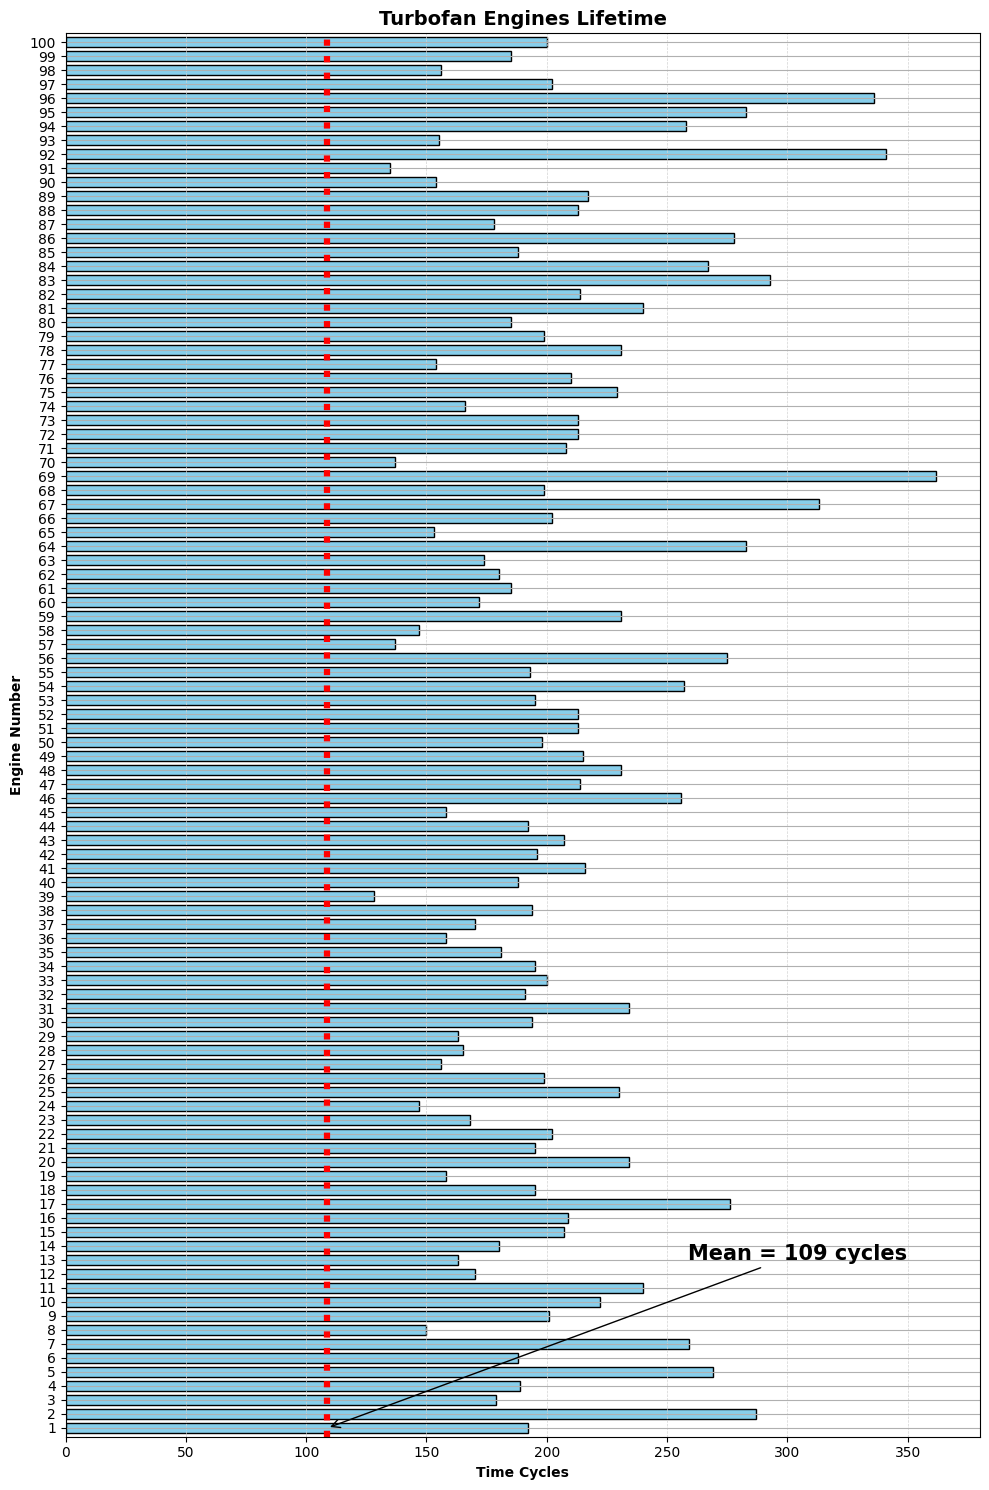

In [19]:
# Agrupa los motores por el maximo ciclo que corre.
max_time_cycles = train_file[eng_info].groupby('unit_number')['time_cycles'].max()
mean_time_cycles = train_file['time_cycles'].mean()

# Distribución
plt.subplots(figsize=(10, 15))
ax = max_time_cycles.plot(kind='barh', width=0.75, color= 'skyblue', edgecolor='black')
plt.title('Turbofan Engines Lifetime', fontweight='bold', fontsize=14)
plt.xlabel('Time Cycles', fontweight='bold', fontsize=10)
plt.ylabel('Engine Number', fontweight='bold', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, which='major', axis='x', linestyle='--', linewidth=0.5, color='#d3d3d3')

ax.axvline(mean_time_cycles, ls='dotted', color='r', linewidth=4.5, label='Mean Time Cycle') 
plt.annotate('Mean = 109 cycles', 
             xy=(mean_time_cycles, 0), 
             xytext=(mean_time_cycles + 150, 12),  # adjust offset as needed
             arrowprops=dict(arrowstyle='->', color='black'),
             fontsize=15, fontweight='bold',  color='black')

plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 9.444444444444459, 'max time cycle')

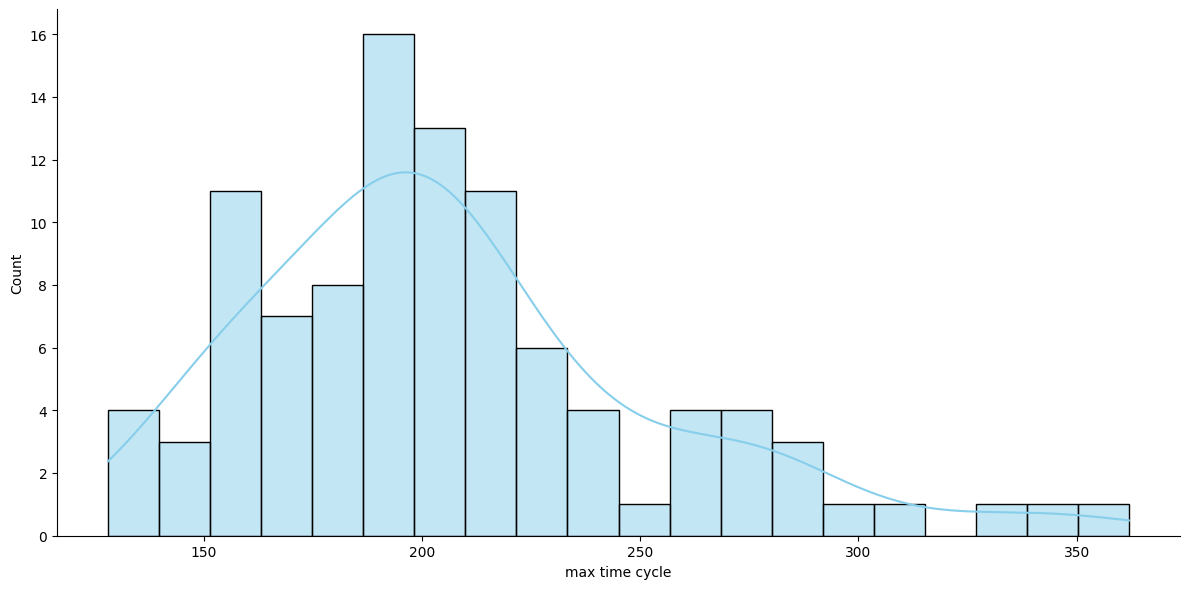

In [20]:
#Distribución de los ciclos de tiempo
#ndex_names = ['unit_number', 'time_cycles']
max_time_cycles = train_file[eng_info].groupby('unit_number').max()

sns.displot(max_time_cycles['time_cycles'],kde=True,bins=20,height=6,aspect=2,  color= 'skyblue', edgecolor='black')
plt.xlabel('max time cycle')

### Analisis de sensores

array([[<Axes: title={'center': 's_1'}>, <Axes: title={'center': 's_2'}>,
        <Axes: title={'center': 's_3'}>, <Axes: title={'center': 's_4'}>,
        <Axes: title={'center': 's_5'}>],
       [<Axes: title={'center': 's_6'}>, <Axes: title={'center': 's_7'}>,
        <Axes: title={'center': 's_8'}>, <Axes: title={'center': 's_9'}>,
        <Axes: title={'center': 's_10'}>],
       [<Axes: title={'center': 's_11'}>,
        <Axes: title={'center': 's_12'}>,
        <Axes: title={'center': 's_13'}>,
        <Axes: title={'center': 's_14'}>,
        <Axes: title={'center': 's_15'}>],
       [<Axes: title={'center': 's_16'}>,
        <Axes: title={'center': 's_17'}>,
        <Axes: title={'center': 's_18'}>,
        <Axes: title={'center': 's_19'}>,
        <Axes: title={'center': 's_20'}>],
       [<Axes: title={'center': 's_21'}>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

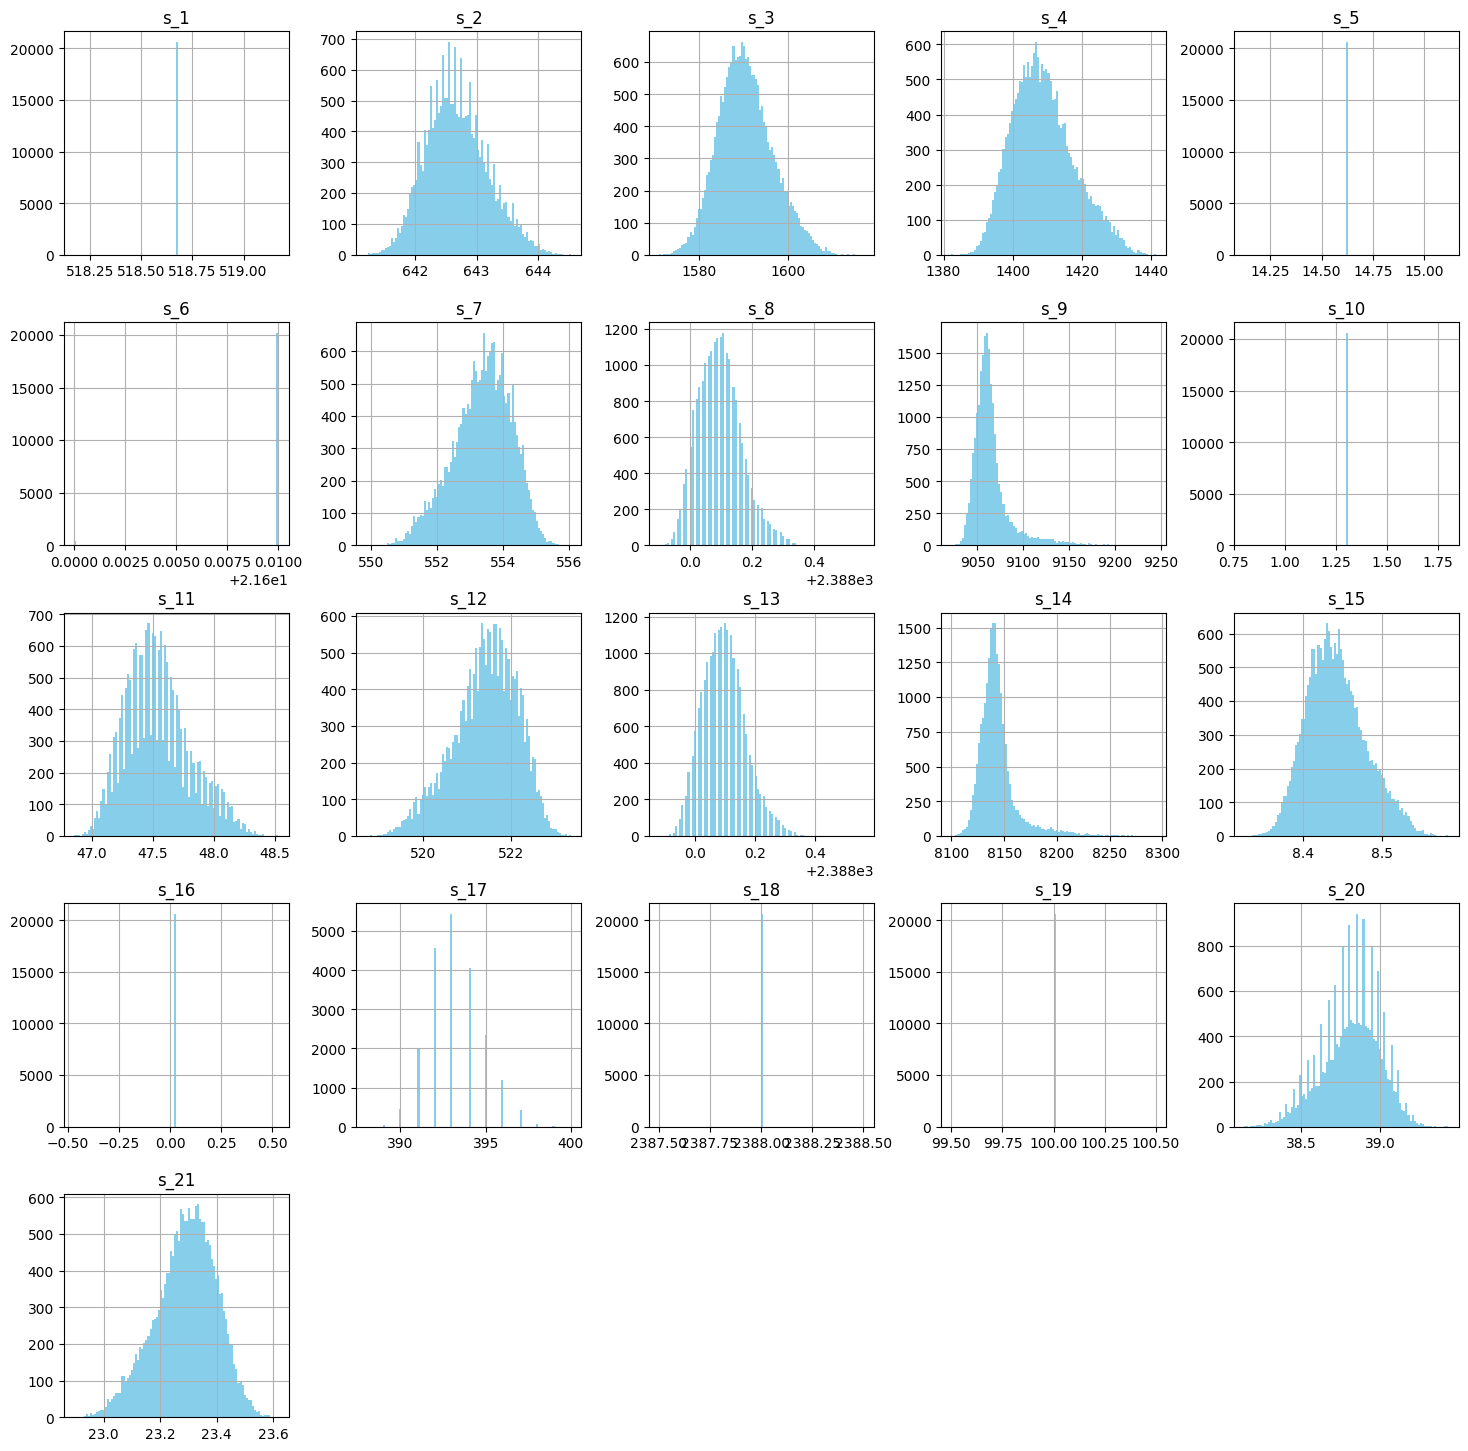

In [21]:
# Distribucion de los sensores 
train_file[sensors_name].hist(bins=100, figsize=(18, 18), color = 'skyblue')

#### Análisis de Correlación entre RUL y sensores 

[Text(0, 0.5, 'unit_number'),
 Text(0, 1.5, 'time_cycles'),
 Text(0, 2.5, 'operational_setting_1'),
 Text(0, 3.5, 'operational_setting_2'),
 Text(0, 4.5, 'operational_setting_3'),
 Text(0, 5.5, 's_1'),
 Text(0, 6.5, 's_2'),
 Text(0, 7.5, 's_3'),
 Text(0, 8.5, 's_4'),
 Text(0, 9.5, 's_5'),
 Text(0, 10.5, 's_6'),
 Text(0, 11.5, 's_7'),
 Text(0, 12.5, 's_8'),
 Text(0, 13.5, 's_9'),
 Text(0, 14.5, 's_10'),
 Text(0, 15.5, 's_11'),
 Text(0, 16.5, 's_12'),
 Text(0, 17.5, 's_13'),
 Text(0, 18.5, 's_14'),
 Text(0, 19.5, 's_15'),
 Text(0, 20.5, 's_16'),
 Text(0, 21.5, 's_17'),
 Text(0, 22.5, 's_18'),
 Text(0, 23.5, 's_19'),
 Text(0, 24.5, 's_20'),
 Text(0, 25.5, 's_21'),
 Text(0, 26.5, 'RUL')]

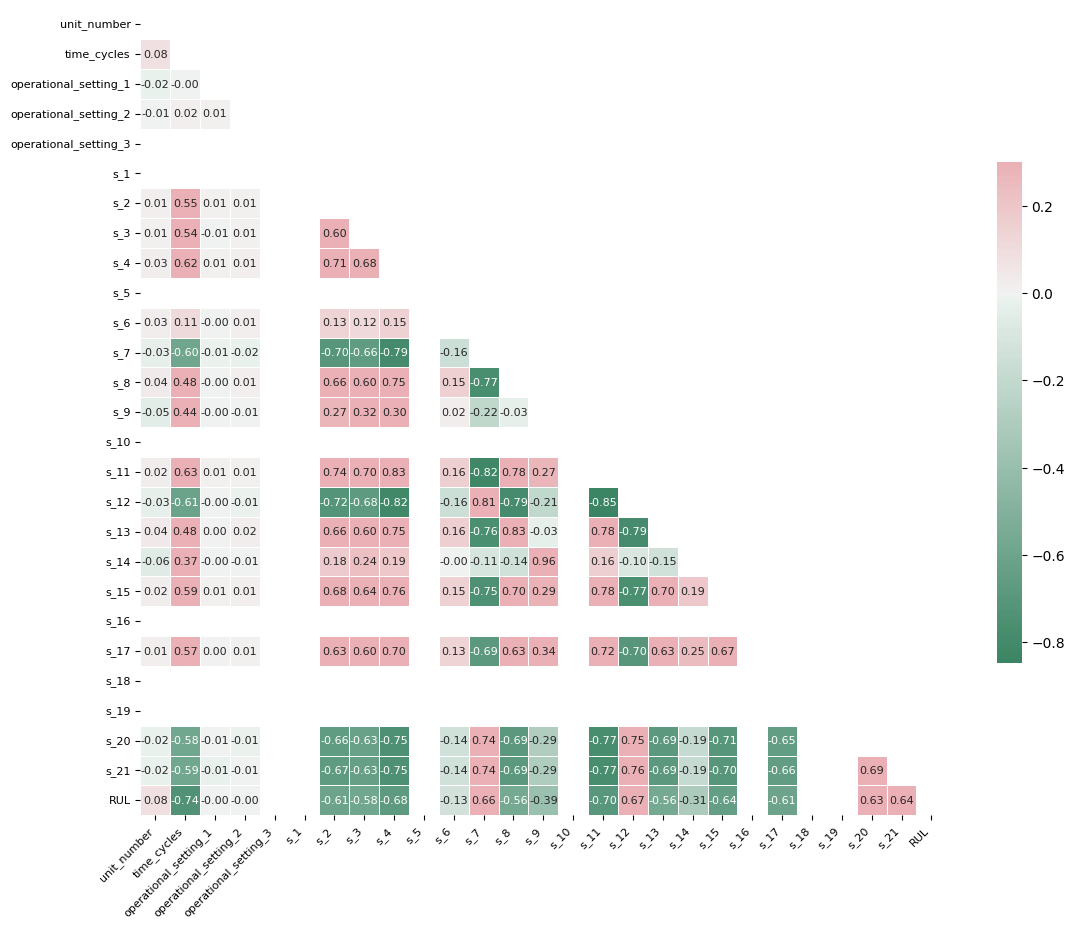

In [22]:
# Creo las correlaciones entre sensores y RUL y observamos que algunos sensores se correlacionan con el RUL. 

corr = train_file.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(13, 13))
cmap = sns.diverging_palette(150, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f", annot_kws={"size":8})

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)

In [23]:
def plot_sensores(train_file, sensor_names, nom_sensor_real, rows=5, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4.5, rows * 3))
    axes = axes.flatten()

    for i, sensor_no in enumerate(sensor_names):
        ax = axes[i]

        for unit in train_file['unit_number'].unique():
            if unit % 10 == 0:
                motor_data = train_file[train_file['unit_number'] == unit]
                smoothed = motor_data[[sensor_no, 'RUL']].rolling(10).mean()
                ax.plot(smoothed['RUL'], smoothed[sensor_no], alpha=0.7)

        ax.set_xlim(250, 0)
        ax.set_title(nom_sensor_real[sensor_no], fontsize=9)  # ✔️ nombre real
        ax.set_xlabel('RUL')
        ax.set_ylabel('Valor')

    # Ocultar subplots vacíos
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


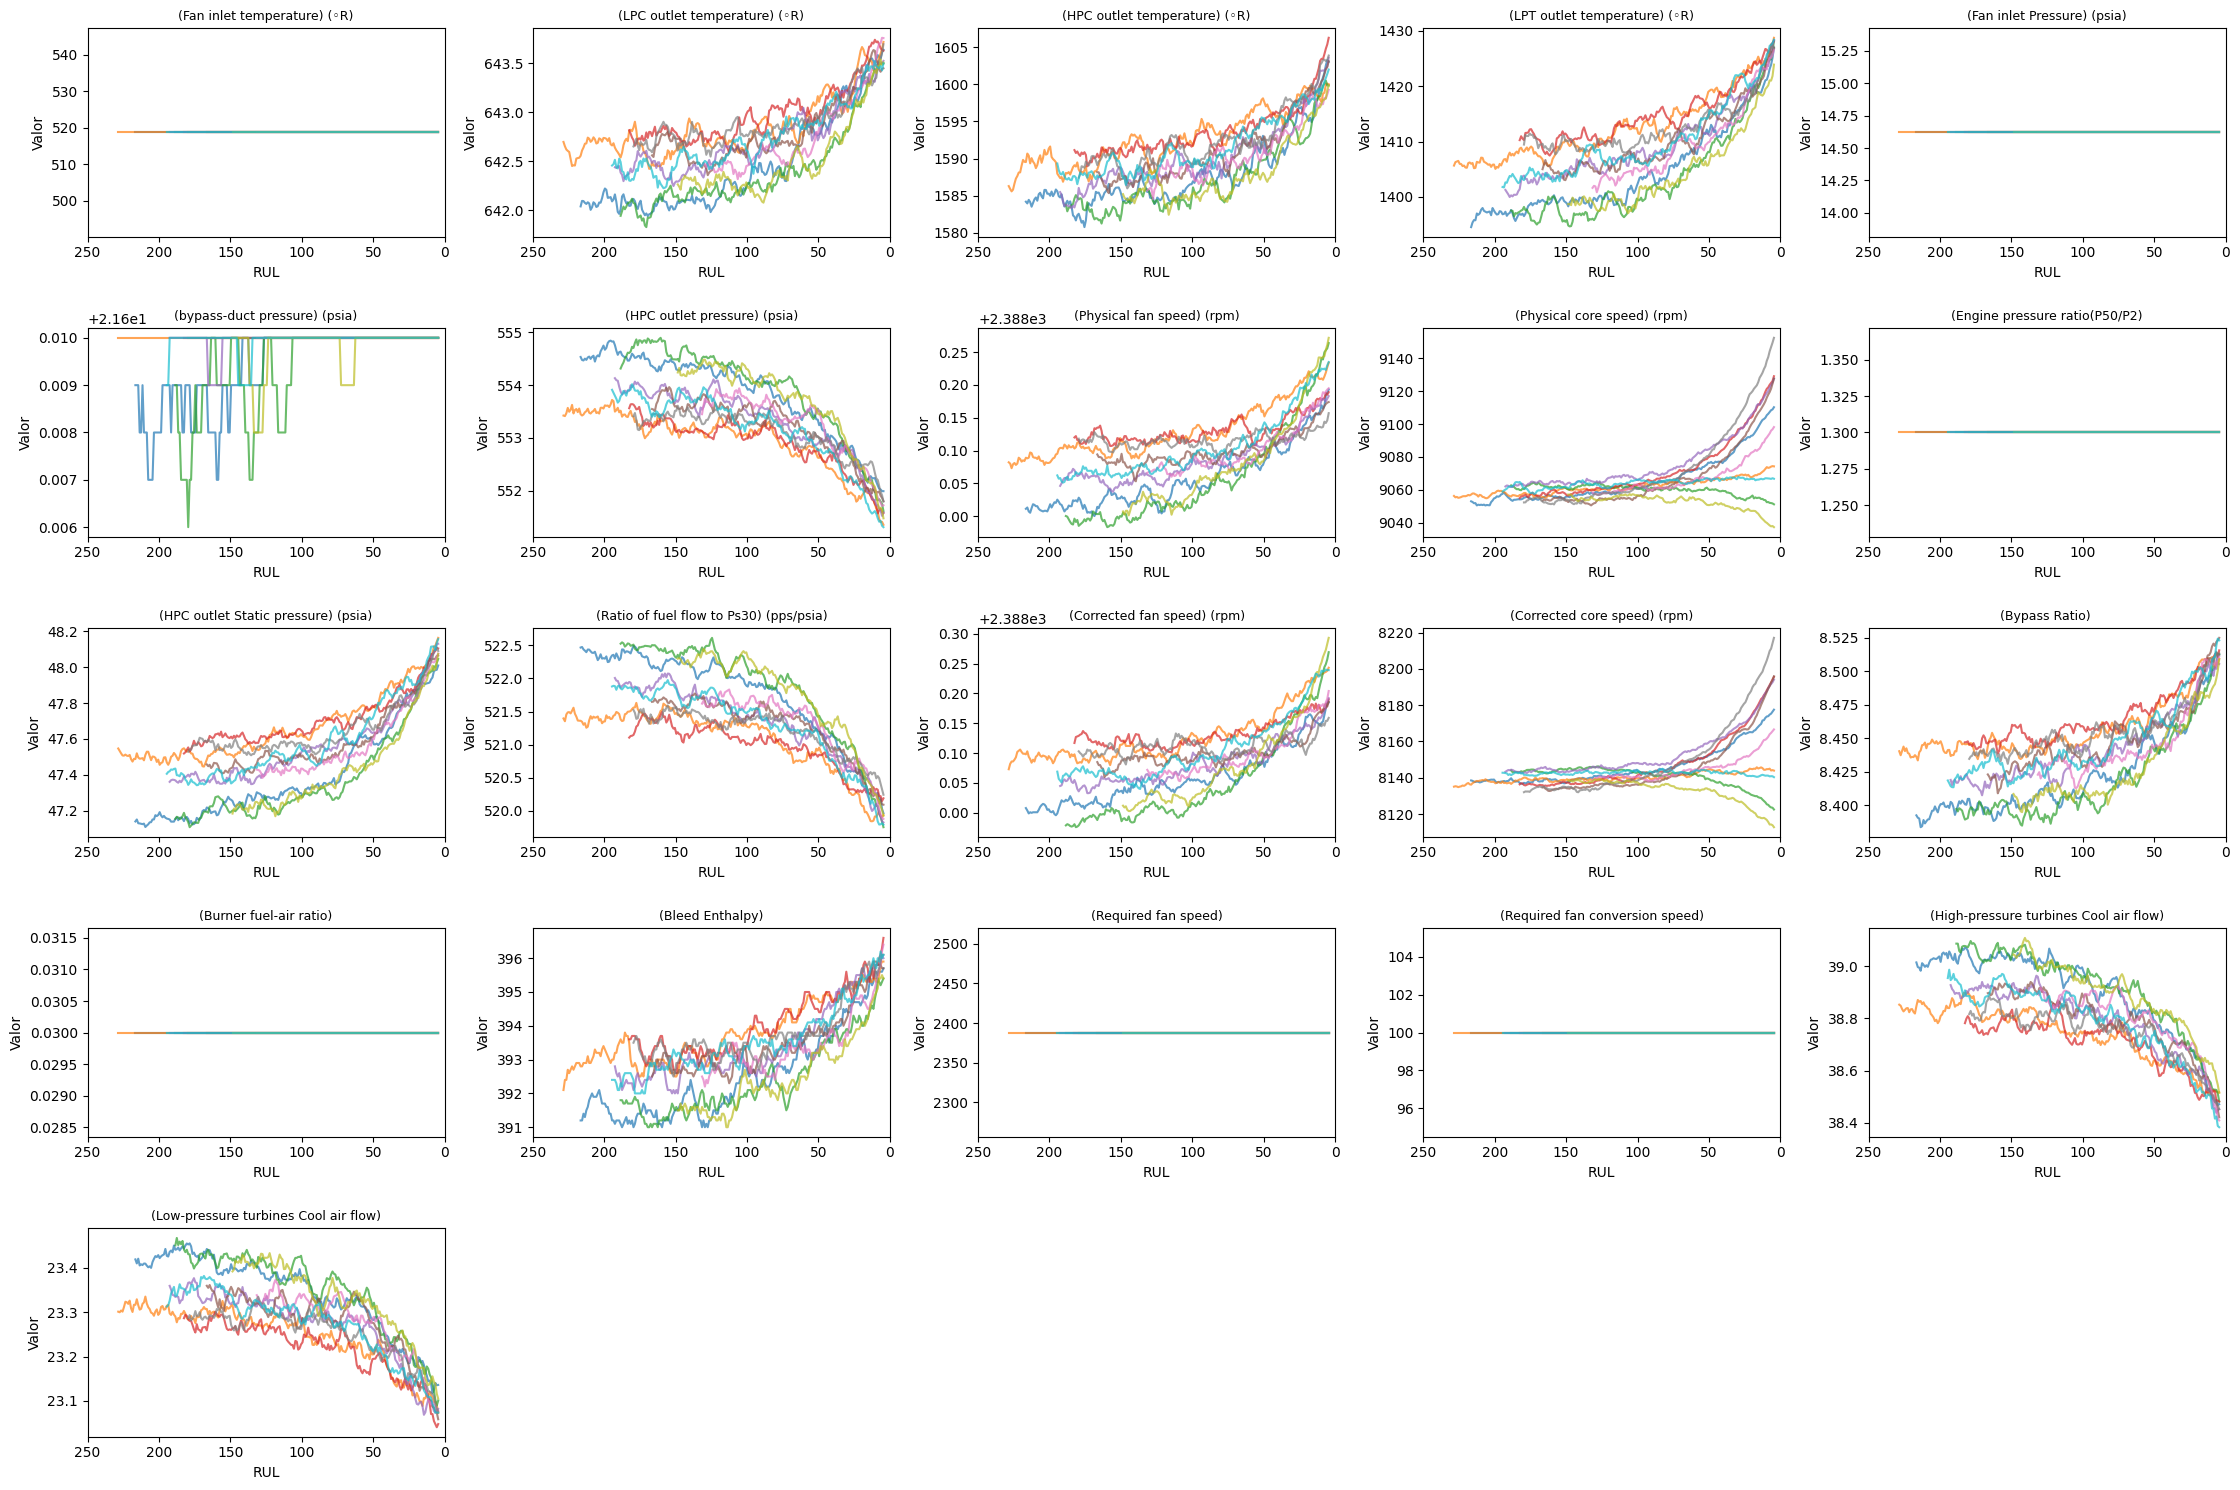

In [24]:
# Un analisis adicional del comportamiento de los sensores contra lo RUL
plot_sensores(train_file, sensors_name, nom_sensor_real, rows=5, cols=5)

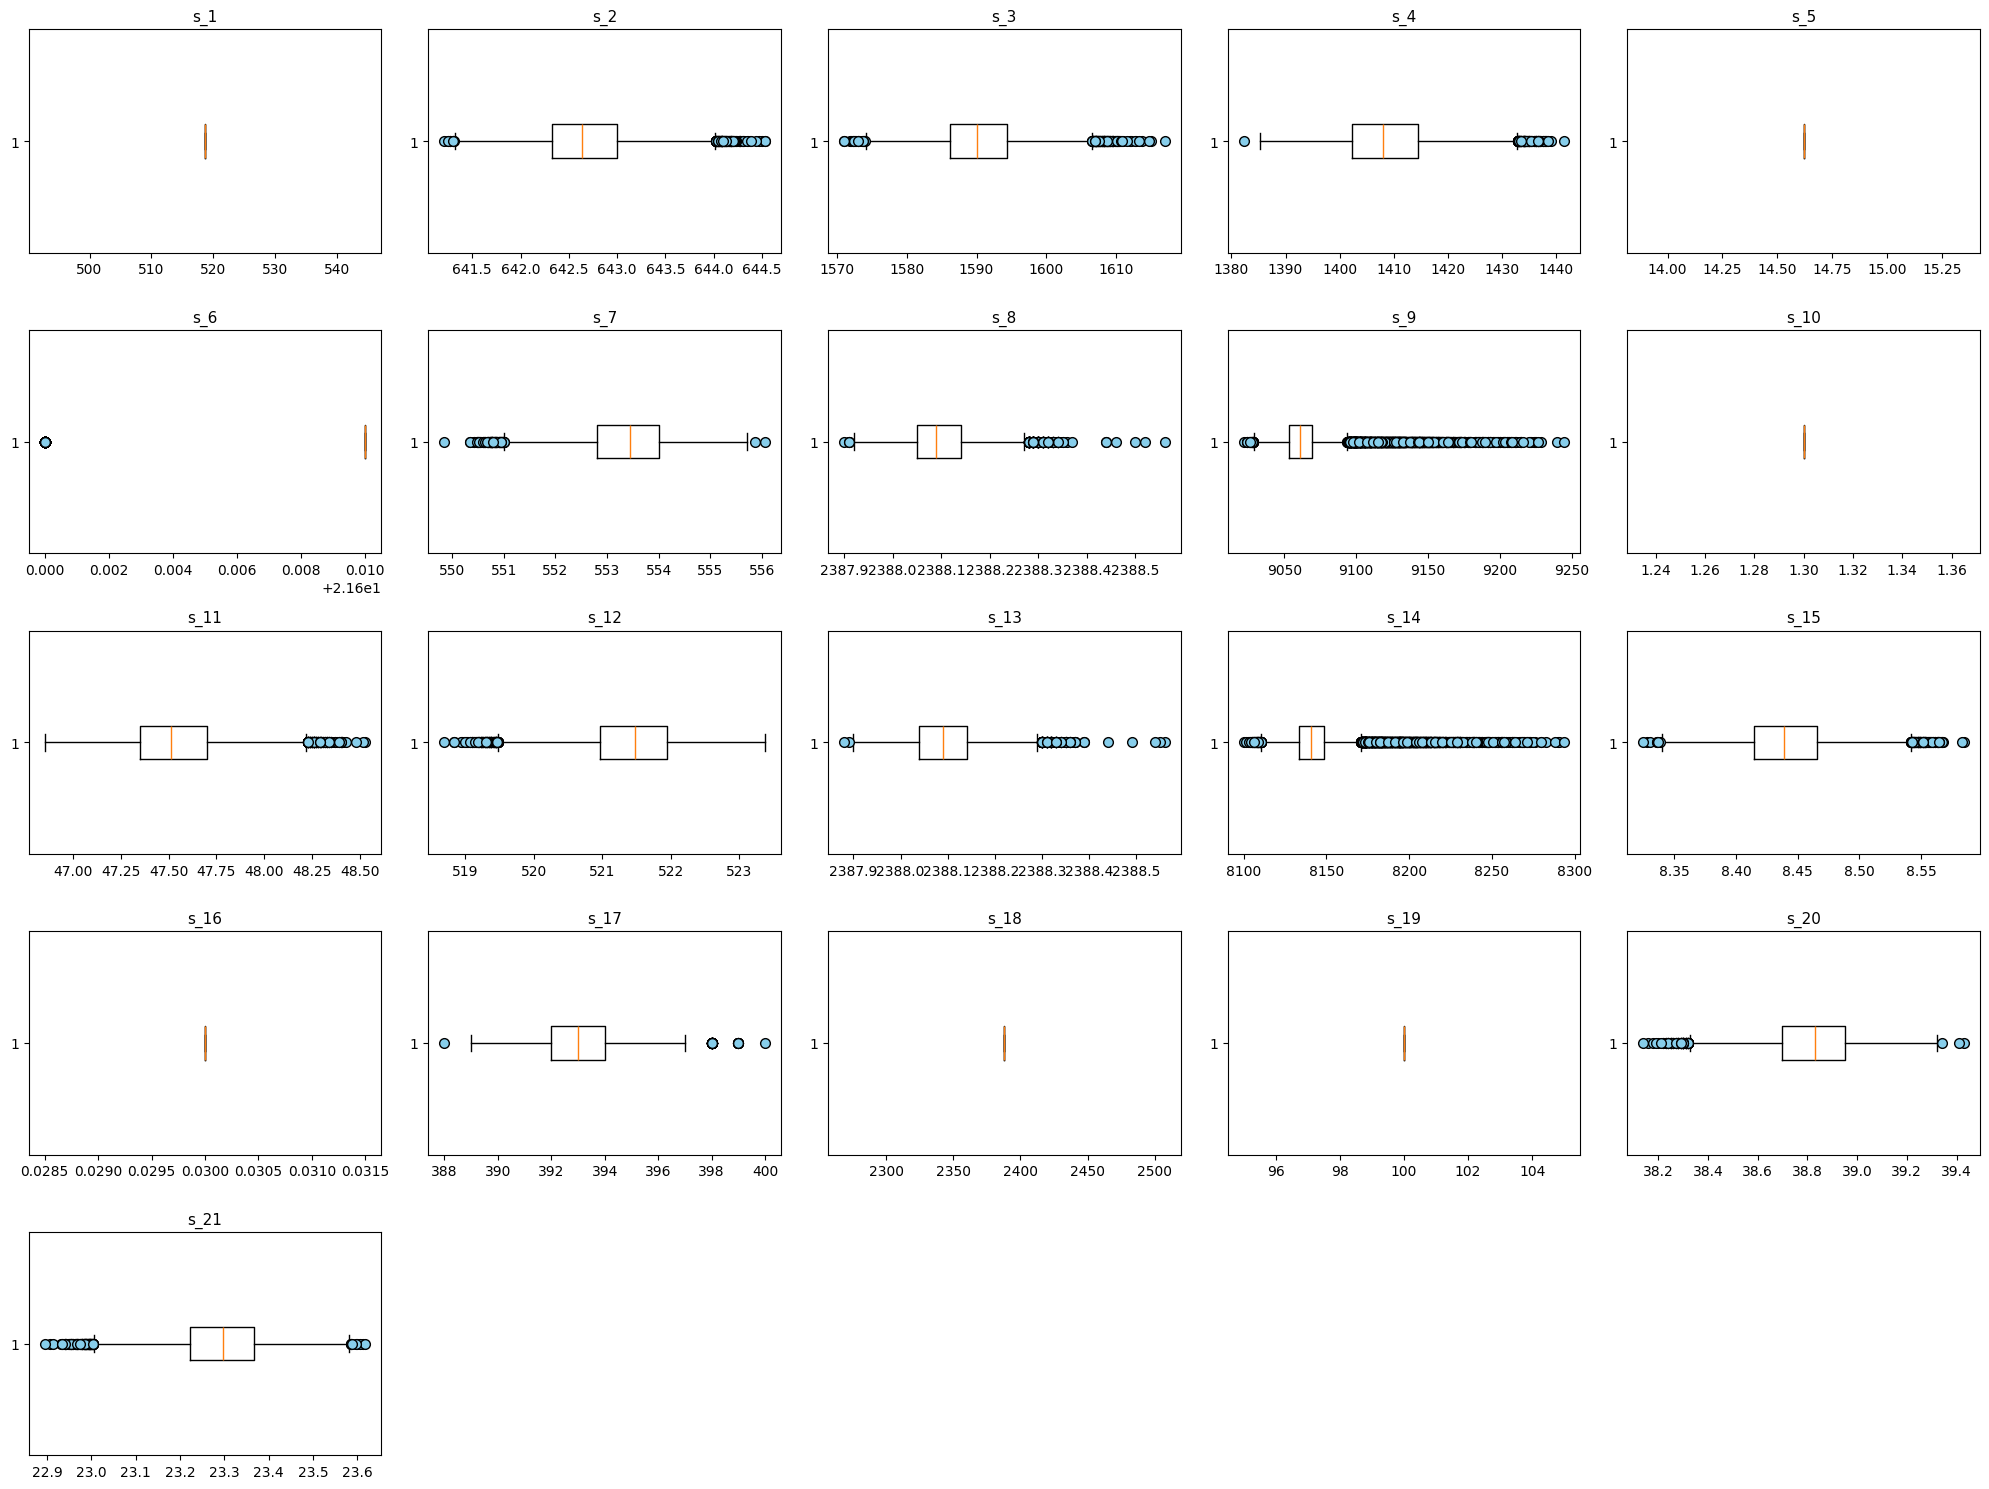

In [25]:
# Análisis de boxplots por sensor, para determinar cuales son constantes y que no esta influyendo en el RUL.
flier_props = dict(marker='o', markerfacecolor='skyblue', markersize=7, linestyle='none')

# Parámetros de la cuadrícula
num_plots = len(sensors_name)
rows = 5
cols = 5

fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
axes = axes.flatten()  # Convierte a lista simple para iterar fácilmente

for i, sensor in enumerate(sensors_name):
    axes[i].boxplot(train_file[sensor], vert=False, flierprops=flier_props)
    axes[i].set_title(sensor, fontsize=11)

# Oculta subplots vacíos
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


### Preparación de datos para Modelos Predictivos

In [26]:
from sklearn.model_selection import train_test_split
drop_labels = eng_info+eng_setting
X_train=train_file.drop(columns=drop_labels).copy()
X_train, X_test, y_train, y_test=train_test_split(X_train,X_train['RUL'], test_size=0.3, random_state=42)

In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#Excluir la variable meta que seria RUL
X_train.drop(columns=['RUL'], inplace=True)
X_test.drop(columns=['RUL'], inplace=True)
#Normalizando X_train y X_test
X_train_s=scaler.fit_transform(X_train)
X_test_s=scaler.fit_transform(X_test)
#Mantiene la ultima corrida para cada motor para igualar la cantidad de registros del archivo de RUL
X_valid = test_file.groupby('unit_number').last().reset_index().drop(columns=drop_labels)
#Normalizar X_valid
X_valid_s=scaler.fit_transform(X_valid)

In [28]:
print(X_valid_s.shape)
print(y_rul.shape)

(100, 21)
(100, 1)


array([[<Axes: title={'center': 's_2'}>, <Axes: title={'center': 's_3'}>,
        <Axes: title={'center': 's_4'}>, <Axes: title={'center': 's_7'}>],
       [<Axes: title={'center': 's_8'}>, <Axes: title={'center': 's_9'}>,
        <Axes: title={'center': 's_11'}>,
        <Axes: title={'center': 's_12'}>],
       [<Axes: title={'center': 's_13'}>,
        <Axes: title={'center': 's_14'}>,
        <Axes: title={'center': 's_15'}>,
        <Axes: title={'center': 's_17'}>],
       [<Axes: title={'center': 's_20'}>,
        <Axes: title={'center': 's_21'}>, <Axes: >, <Axes: >]],
      dtype=object)

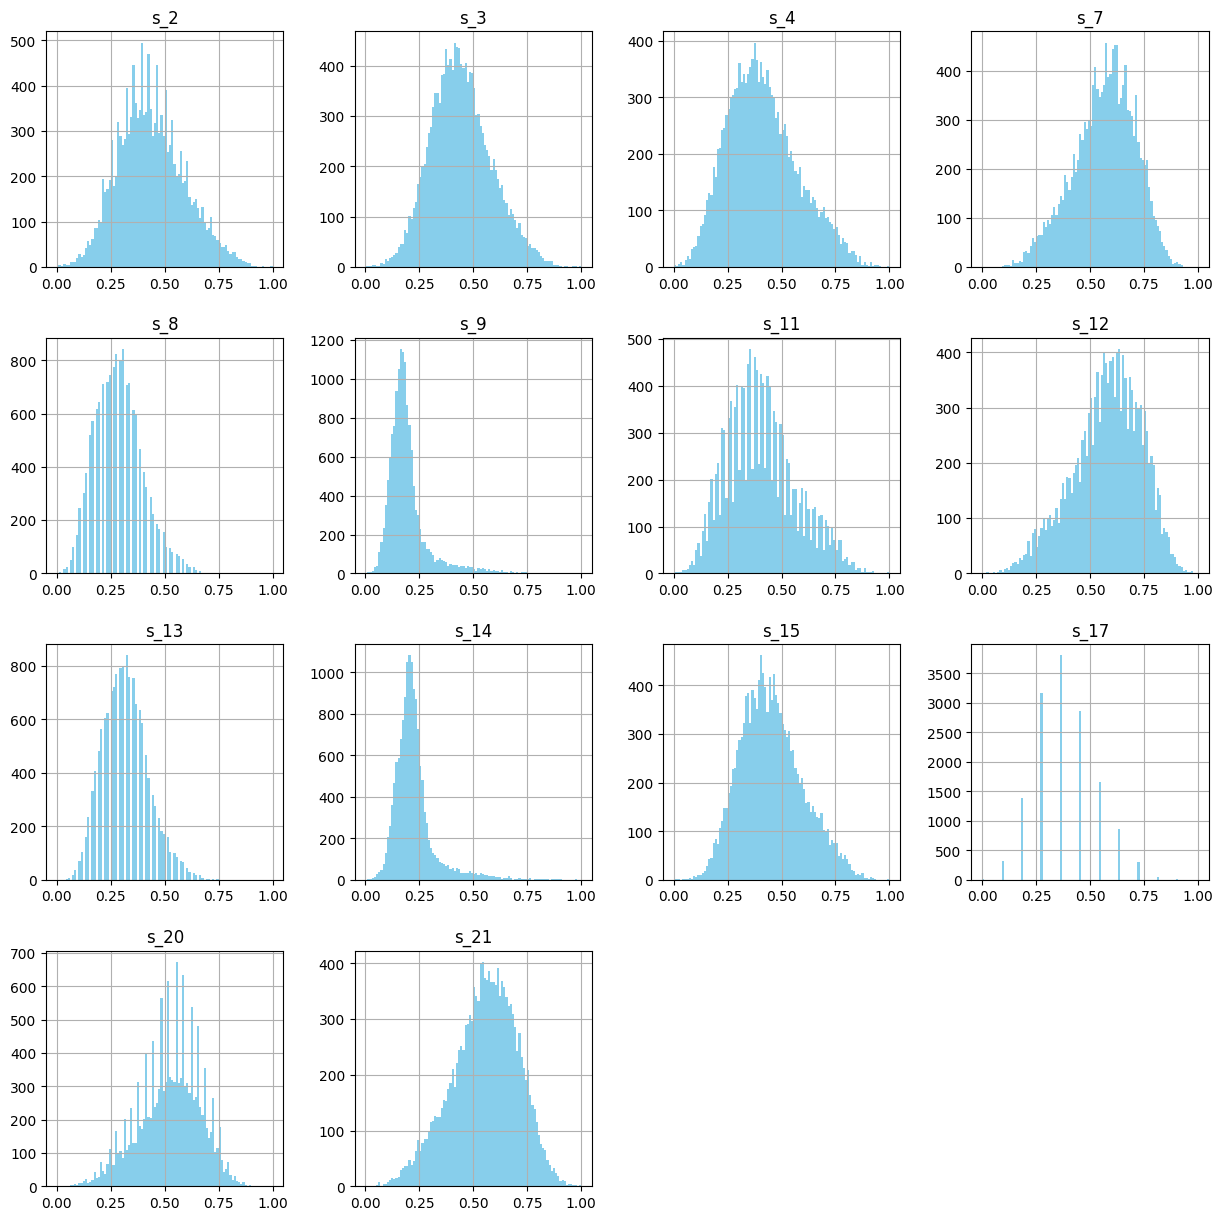

In [29]:
sensores=['s_{}'.format(i) for i in range(1,22) if i not in [1,5,6,10,16,18,19]]
pd.DataFrame(X_train_s,columns=['s_{}'.format(i) for i in range(1,22)])[sensores].hist(bins=100, figsize=(15,15), color= "skyblue")

### Random forest 1
#### Escenario incluyendo todos los sensores.

In [30]:
rf = RandomForestRegressor(max_features="sqrt", random_state=42)

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate(y_true, y_hat, label='test'):
    mae = mean_absolute_error(y_true, y_hat)
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_hat)
    
    print(f'{label} set:')
    print(f'  ✅ MAE:  {mae:.2f}')
    print(f'  ✅ RMSE: {rmse:.2f}')
    print(f'  ✅ R²:   {r2:.4f}')

In [32]:
#plot real data and the predicted one to make some comparison
def plot_predActual(y_test, y_test_hat):
  
    indices = np.arange(len(y_test_hat))
    wth= 0.6
    plt.figure(figsize=(70,30))
    true_values = [int(x) for x in y_test.values]
    predicted_values = list(y_test_hat)

    plt.bar(indices, true_values, width=wth,color='b', label='True RUL')
    plt.bar([i for i in indices], predicted_values, width=0.5*wth, color='r', alpha=0.7, label='Predicted RUL')

    plt.legend(prop={'size': 40})
    plt.tick_params(labelsize=40)

    plt.show()

In [33]:
# gridsearch goes here
rf.fit(X_train_s, y_train)
# predict and evaluate
y_rf_train = rf.predict(X_train_s)
evaluate(y_train,y_rf_train, label='train')

y_rf_test = rf.predict(X_test_s)
evaluate(y_test, y_rf_test, label='test')

y_rf_valid = rf.predict(X_valid_s)
evaluate(y_rul, y_rf_valid, label='valid')

train set:
  ✅ MAE:  10.83
  ✅ RMSE: 15.41
  ✅ R²:   0.9507
test set:
  ✅ MAE:  30.99
  ✅ RMSE: 44.36
  ✅ R²:   0.5703
valid set:
  ✅ MAE:  23.50
  ✅ RMSE: 30.65
  ✅ R²:   0.4559


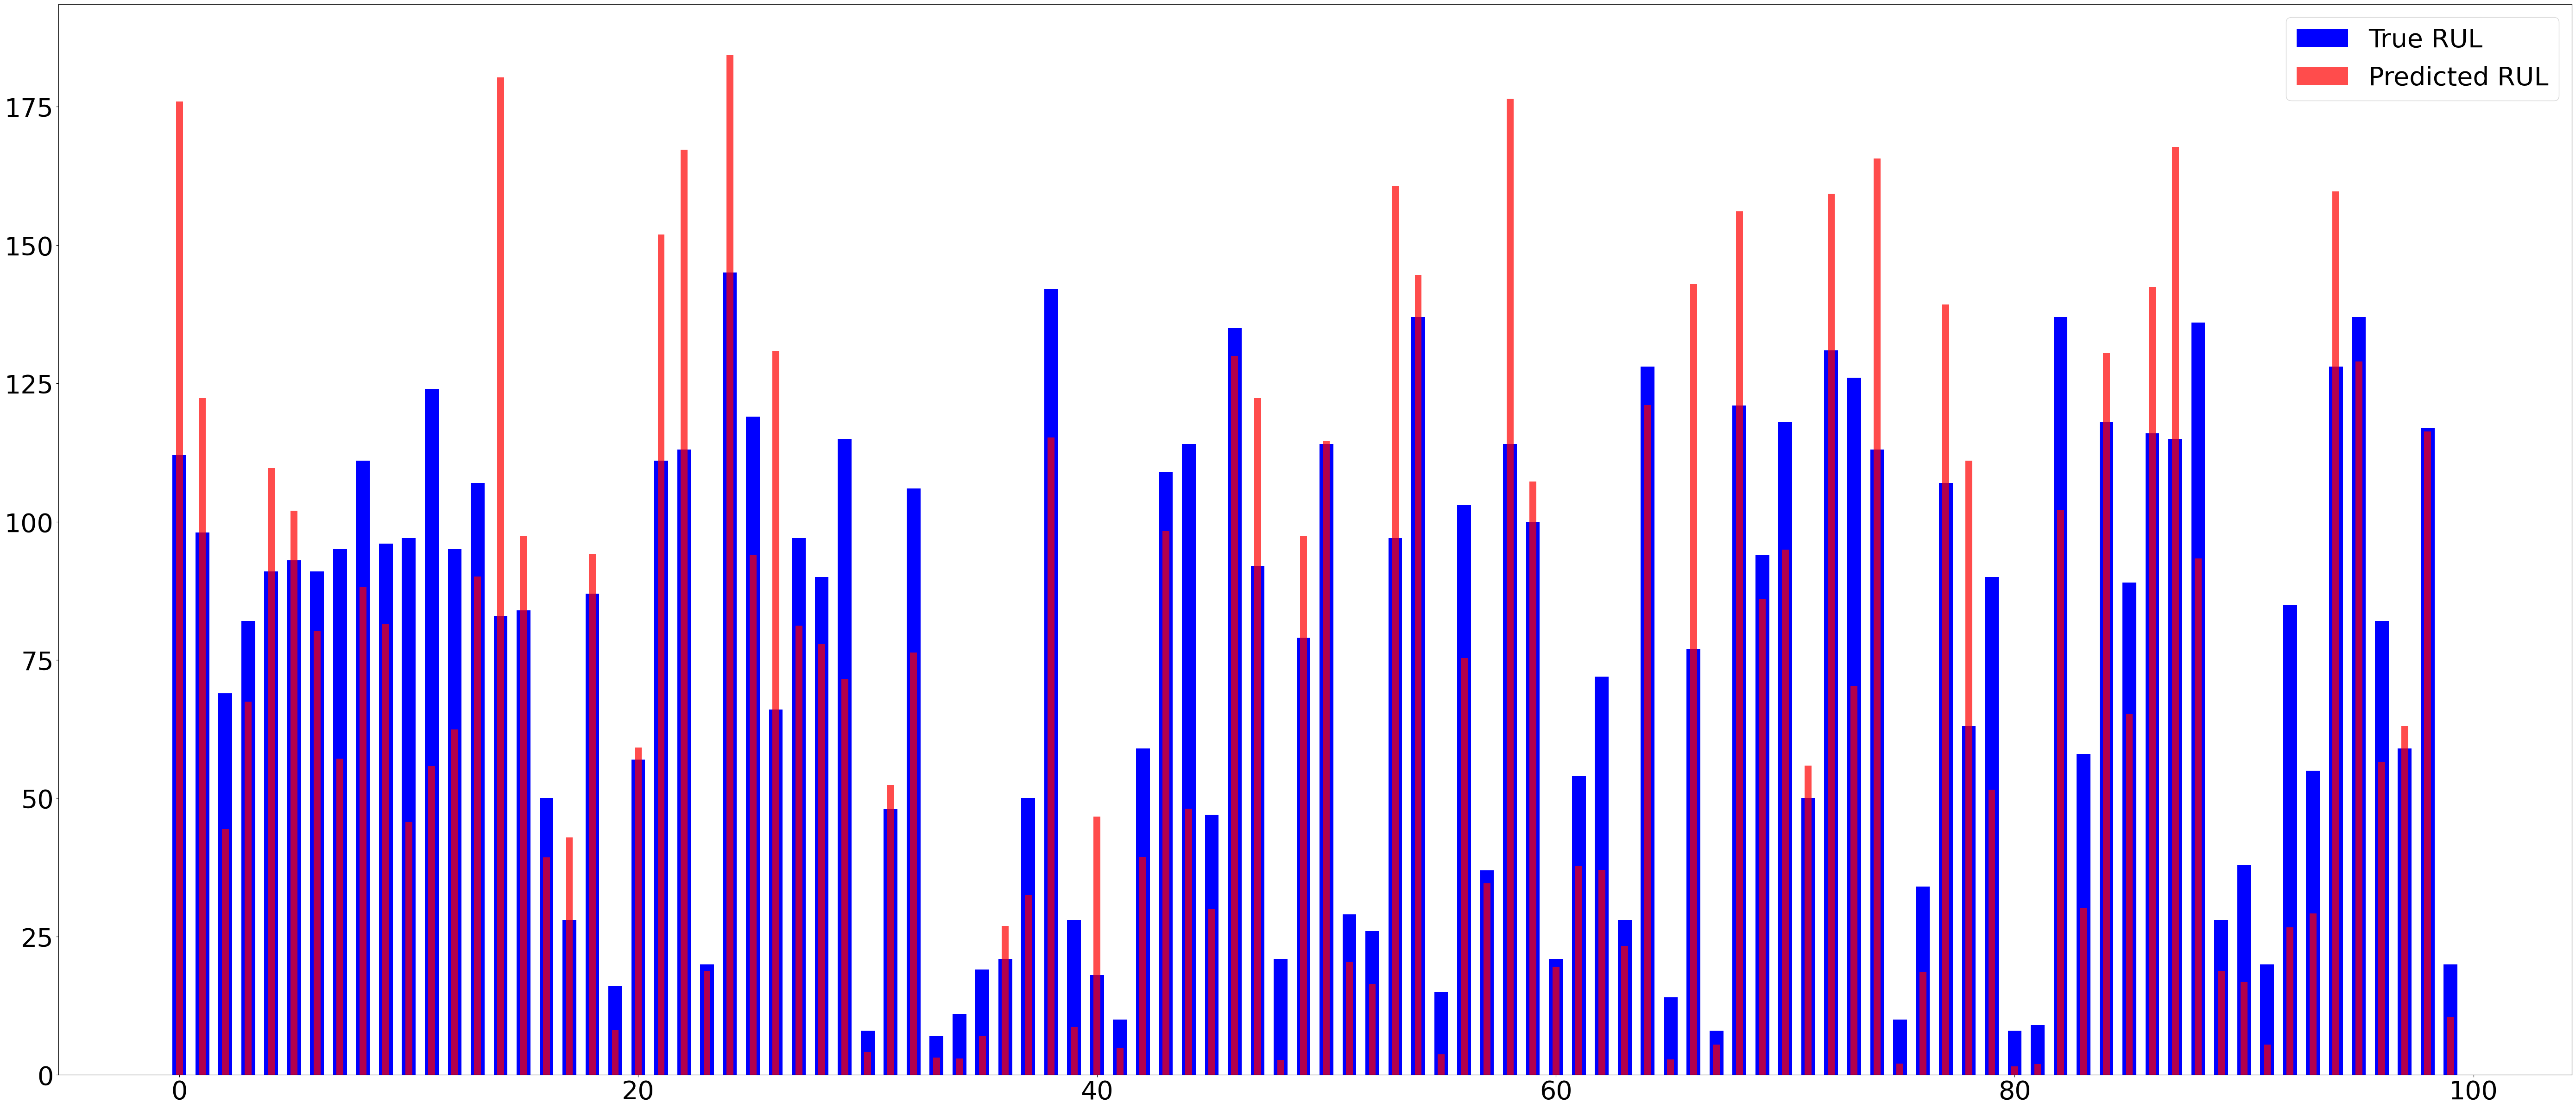

In [34]:
plot_predActual(y_rul, y_rf_valid)

### Regresión Lineal 2
##### Escenario excluyendo los sensores con valores constantes

In [35]:
print('maximum of y_train : ',y_train.max())
print('maximum of y_test : ',y_test.max())
print('maximum of y_valid : ',y_rul.max())

maximum of y_train :  361
maximum of y_test :  360
maximum of y_valid :  RUL    145
dtype: int64


In [36]:
drop_labels2=['s_1', 's_5','s_6','s_10',  's_16', 's_18', 's_19']
X_train_2=X_train.drop(columns=drop_labels2, axis=1) # drop the constant columns from the train dataset
X_test_2=X_test.drop(columns=drop_labels2, axis=1)  # drop the constant columns from the test dataset
X_train_2_s=scaler.fit_transform(X_train_2) #scaling X_train_2
X_test_2_s=scaler.fit_transform(X_test_2) #scaling X_test_2
y_train_clip=y_train.clip(upper=195)  #Clipping y_train to have 195 as the maximum value 
X_valid_2=X_valid.drop(columns=drop_labels2, axis=1)  # drop the constant columns from the validation dataset
X_valid_2_s=scaler.fit_transform(X_valid_2) #scaling X_valid_2

In [37]:
rf.fit(X_train_2_s, y_train_clip)
# predict and evaluate
y_rf_train = rf.predict(X_train_2_s)
evaluate(y_train_clip,y_rf_train, label='train')

y_rf_test = rf.predict(X_test_2_s)
evaluate(y_test, y_rf_test, label='test')

y_rf_valid = rf.predict(X_valid_2_s)
evaluate(y_rul, y_rf_valid, label='valid')

train set:
  ✅ MAE:  9.12
  ✅ RMSE: 12.04
  ✅ R²:   0.9607
test set:
  ✅ MAE:  31.49
  ✅ RMSE: 45.82
  ✅ R²:   0.5417
valid set:
  ✅ MAE:  20.49
  ✅ RMSE: 26.55
  ✅ R²:   0.5919


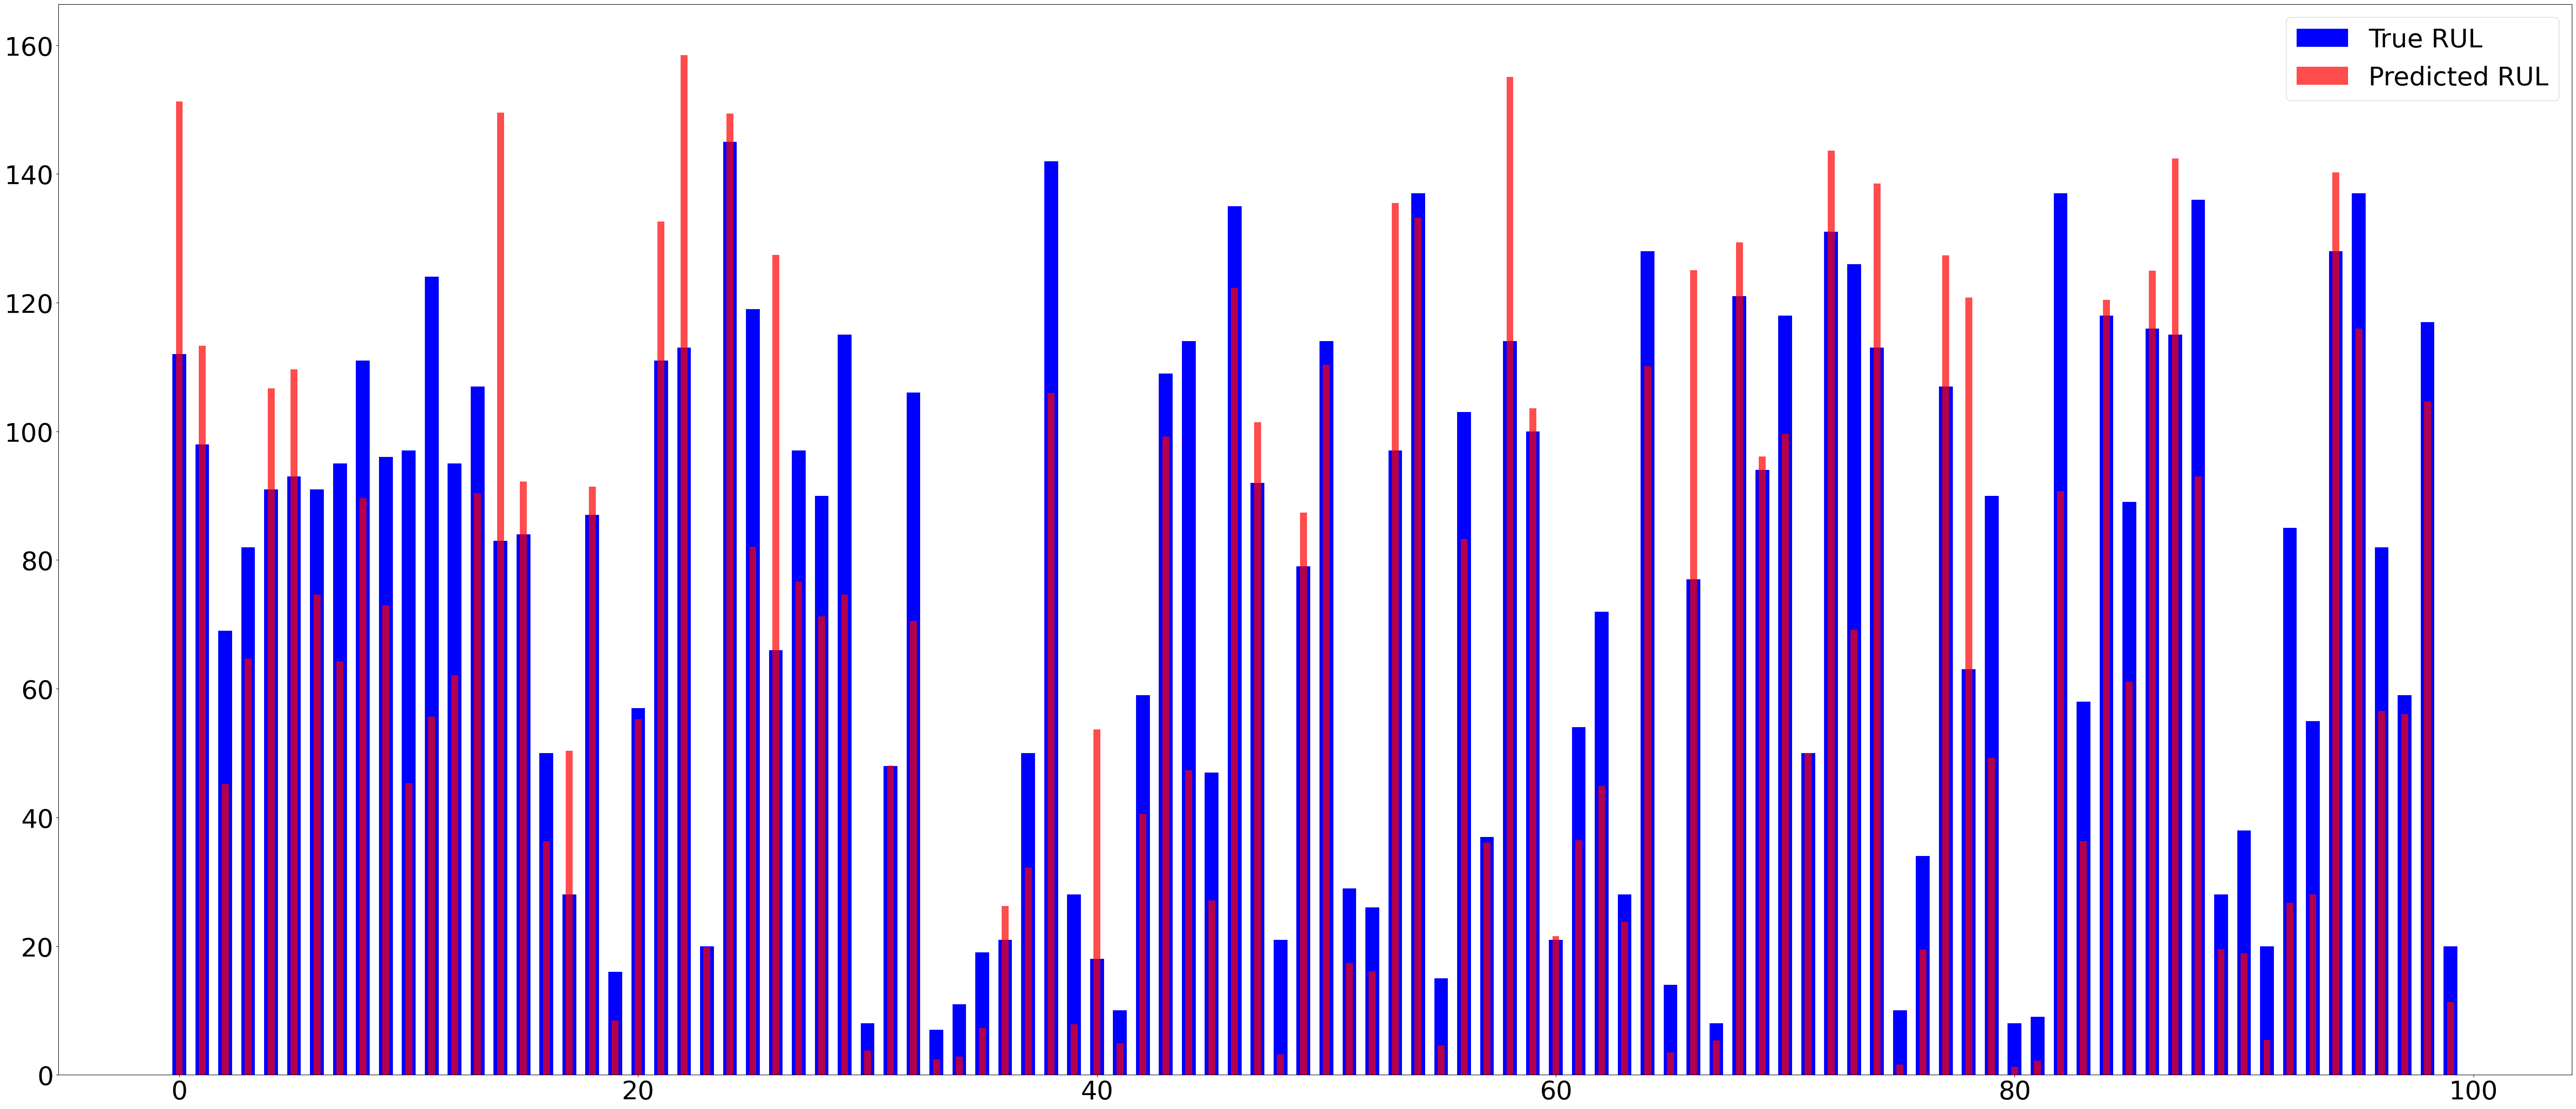

In [38]:
plot_predActual(y_rul, y_rf_valid)

### Regresión Lineal 3
#### Escenario excluyendo sensores constantes y toda la data. 

In [41]:
df=train_file.copy()
for x in X_train_2.columns:
    df[x+'_rm']=0

df.columns

Index(['unit_number', 'time_cycles', 'operational_setting_1',
       'operational_setting_2', 'operational_setting_3', 's_1', 's_2', 's_3',
       's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11', 's_12',
       's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21',
       'RUL', 's_2_rm', 's_3_rm', 's_4_rm', 's_7_rm', 's_8_rm', 's_9_rm',
       's_11_rm', 's_12_rm', 's_13_rm', 's_14_rm', 's_15_rm', 's_17_rm',
       's_20_rm', 's_21_rm'],
      dtype='object')

In [42]:
drop_labels2=['s_1', 's_5','s_6','s_10',  's_16', 's_18', 's_19']

df=df.drop(columns=eng_setting+drop_labels2+['RUL'], axis=1)

X_valid_3=test_file.drop(columns=eng_info+eng_setting+drop_labels2, axis=1)

In [43]:
def update_rolling_mean(data, mask):
    for x, group in mask.groupby("unit_number"):
        for x in X_train_2.columns:
            data.loc[group.index[10:], x+"_rm"] = data.loc[group.index, x].rolling(10).mean()[10:]
            data.loc[group.index[:10], x+"_rm"] = data.loc[group.index[:10], x]

update_rolling_mean(df, df)
update_rolling_mean(X_valid_3, test_file)

X_valid_3=X_valid_3.fillna(0)

In [44]:
df.iloc[-1,-14:]=df.iloc[-2,-14:]
X_valid_3.iloc[-1,-14:]=X_valid_3.iloc[-2,-14:]

In [45]:
train_tm=df

In [46]:
train_tm=train_tm.drop(columns=eng_info, axis=1)

In [47]:
X_train_tm, X_test_tm, y_train_tm, y_test_tm=train_test_split(train_tm,train_file['RUL'].clip(upper=195), test_size=0.35, random_state=42)
X_train_tm_s=scaler.fit_transform(X_train_tm)
X_test_tm_s=scaler.fit_transform(X_test_tm)
X_val3=pd.concat([test_file['unit_number'],X_valid_3],axis=1)
X_valid3 = X_val3.groupby('unit_number').last().reset_index().drop(columns=['unit_number'])
X_valid_s=scaler.fit_transform(X_valid3)

In [48]:
rf = RandomForestRegressor(max_features="sqrt", random_state=42)
rf.fit(X_train_tm_s, y_train_tm)
# predict and evaluate
y_hat_train = rf.predict(X_train_tm_s)
evaluate(y_train_tm,y_hat_train, label='train')
y_hat_test = rf.predict(X_test_tm_s)
evaluate(y_test_tm, y_hat_test, label='test')
y_hat_valid = rf.predict(X_valid_s)
evaluate(y_rul, y_hat_valid, label='valid')

train set:
  ✅ MAE:  7.21
  ✅ RMSE: 9.79
  ✅ R²:   0.9740
test set:
  ✅ MAE:  22.50
  ✅ RMSE: 29.96
  ✅ R²:   0.7514
valid set:
  ✅ MAE:  28.72
  ✅ RMSE: 37.19
  ✅ R²:   0.1990


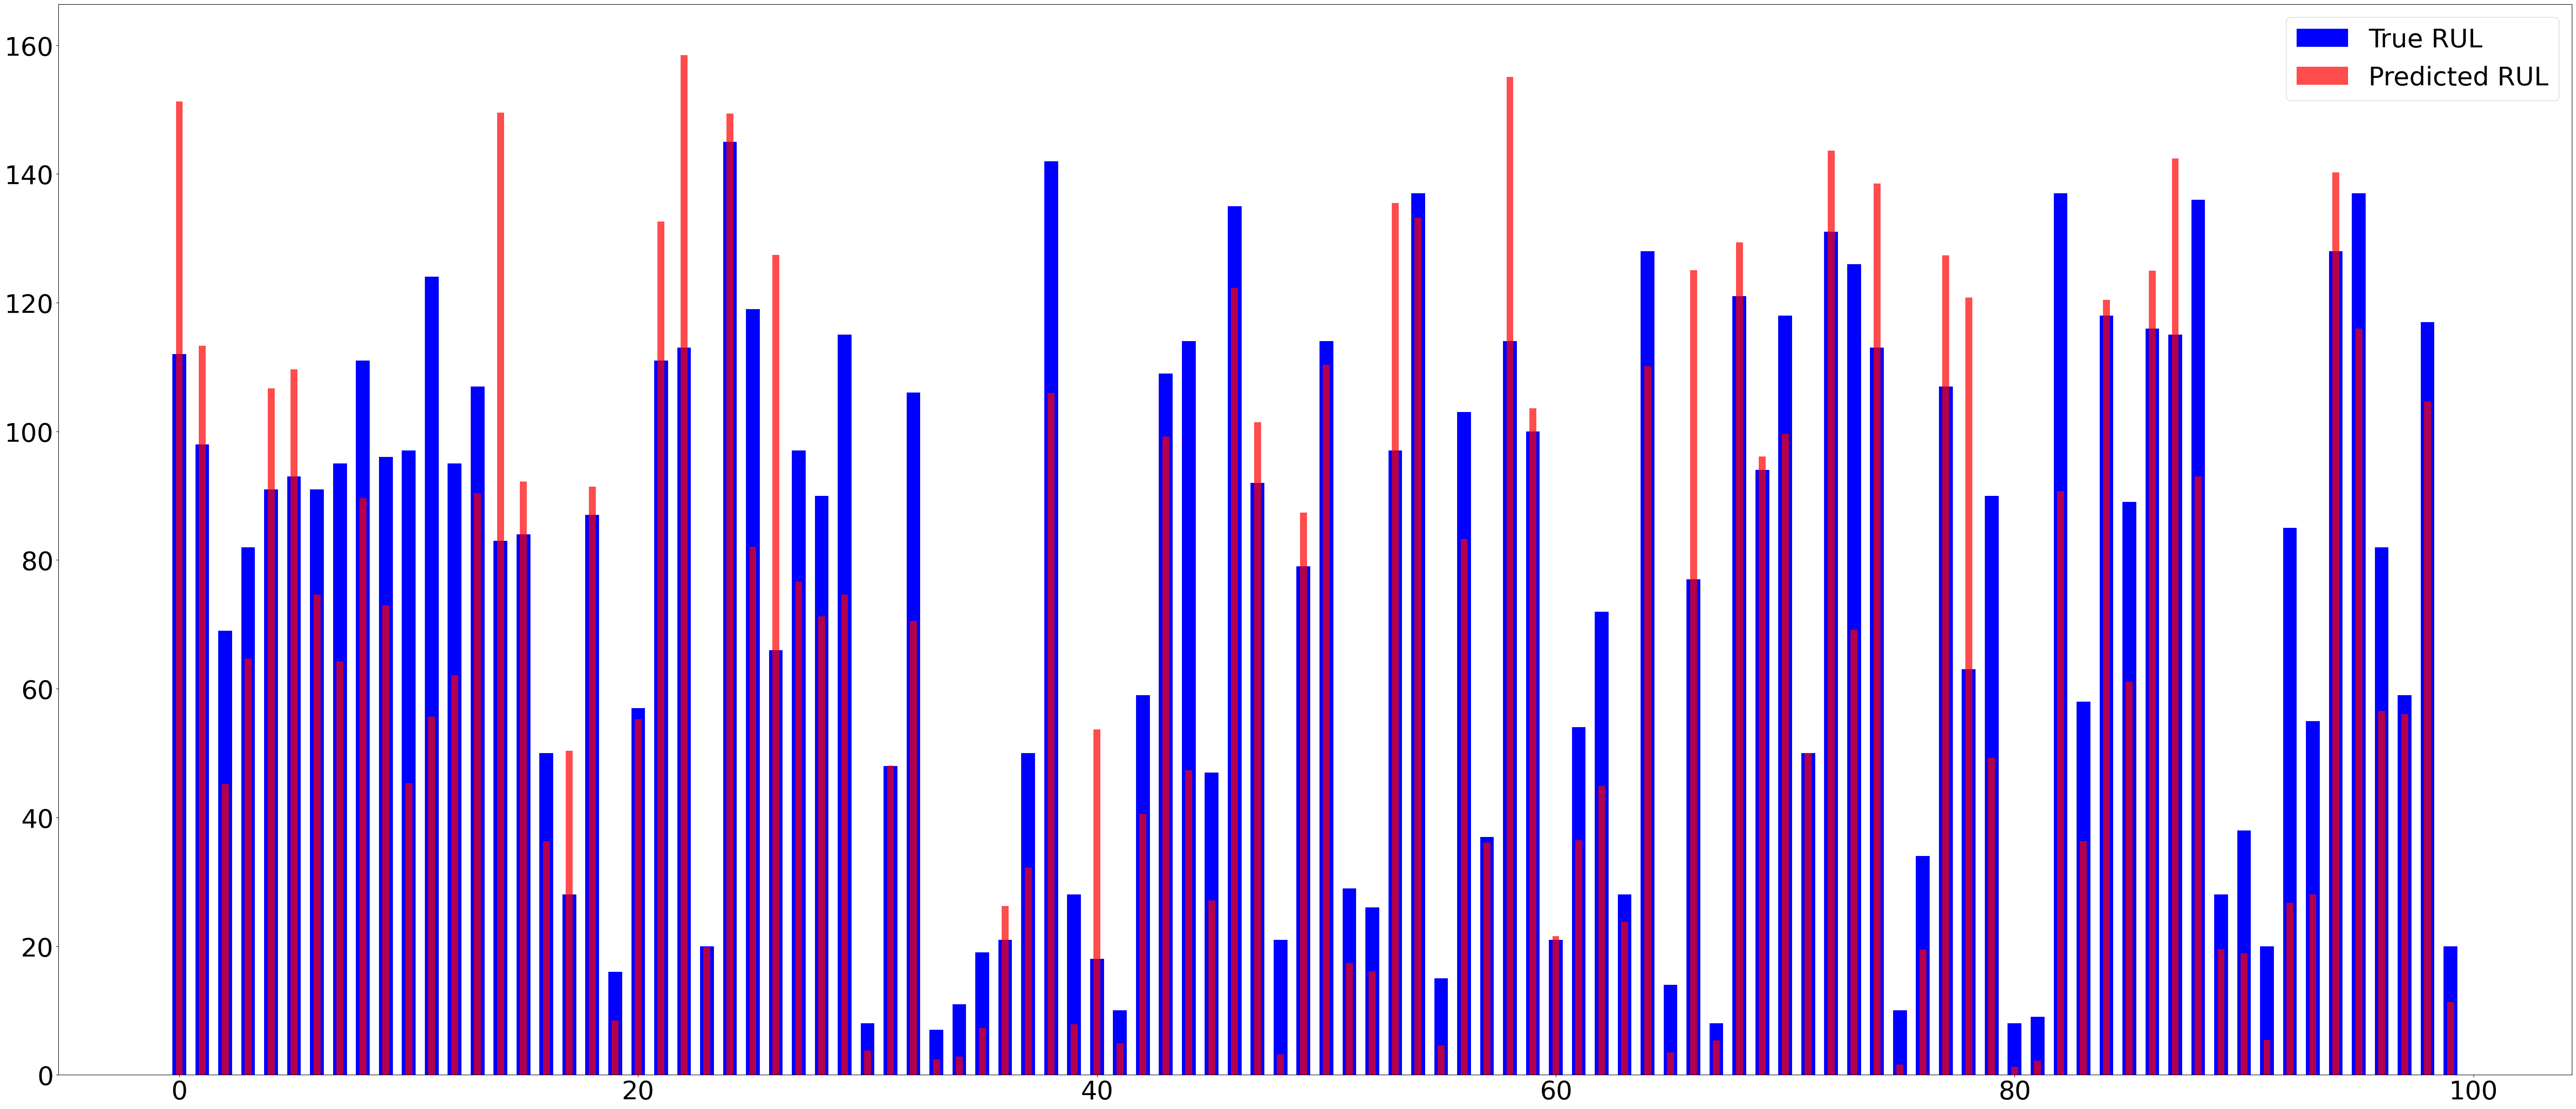

In [49]:
plot_predActual(y_rul, y_rf_valid)